# Assignment 08

**Due:** 2015-04-26 (Thurs), 11:59 PM, as an IPython notebook (with related files) submitted via your repo in the course GitHub organization.  Use the solutions template notebook, and **be sure not to modify the subproblem cells** in your solution file.

In [1]:
# The usual imports:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from scipy import *
from scipy import stats

ion()

In [2]:
# StanFitter:
from stanfitter import StanFitter

In [3]:
# Import a class and two plotting functions from bivar_helpers:
from bivar_helpers import MargCondJoint2D, traceplots, betas_plot

In [4]:
# True intercept, slope of y regression line, and cond'l std dev'n:
beta_0 = 1.
beta_1 = 2.
csig_y = 1.

def y_normal_x(x):
    """
    Return a normal dist'n for y given x, with a straight-line regression
    function.
    """
    return stats.norm(beta_0 + beta_1*x, csig_y)


In [5]:
# Normal marginal for x:
mu_x = 5.
sig_x = 1.
x_norm = stats.norm(mu_x, sig_x)

In [6]:
# Uniform marginal for x:
w = 8.
x_l = mu_x - w/2.
x_u = mu_x + w/2.
sig_x_u = w/sqrt(12.)  # var of uniform is w/12
x_uniform = stats.uniform(x_l, w)

In [7]:
n_case = MargCondJoint2D(x_norm, y_normal_x)
u_case = MargCondJoint2D(x_uniform, y_normal_x)

n = 100
xvals_n, yvals_n = n_case.sample(n)
xvals_u, yvals_u = u_case.sample(n)

Text(0,0.5,'$y$')

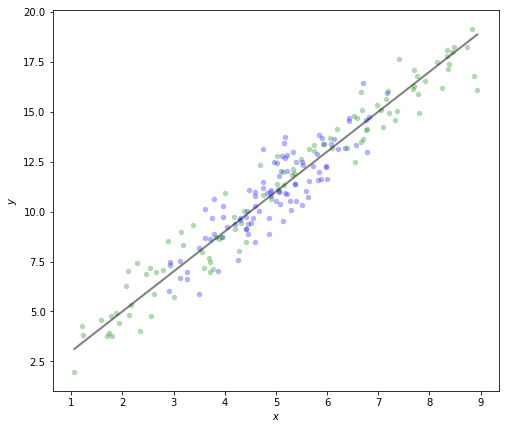

In [8]:
figure(figsize=(8,7))
scatter(xvals_n, yvals_n, s=30, c='b', linewidths=0, alpha=.3)
scatter(xvals_u, yvals_u, s=30, c='g', linewidths=0, alpha=.3)
# True regression line:
xvals = linspace(xvals_u.min(), xvals_u.max(), 3)
yvals = beta_0 + beta_1*xvals
plot(xvals, yvals, 'k-', lw=2, alpha=.5)
xlabel('$x$')
ylabel('$y$')

### Normal marginal case

The following Stan code describes the normal marginal case (i.e., a conditionally-specified bivariate normal); it adopts broad normal priors for the regression coefficients. This code could have been provided in a separate ".stan" file, but for the assignment you should use a code string in the notebook.

In [9]:
normal_code = """
data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples
}

parameters {
    real beta_0;
    real beta_1;
}

model {
    beta_0 ~ normal(0, 10.);  // prior is a wide normal
    beta_1 ~ normal(0, 10.);
    for (i in 1:n) {
        x[i] ~ normal(%f, %f);  // normal marginal for x
        y[i] ~ normal(beta_0 + beta_1*x[i], 1.);
    }
}
""" % (mu_x, sig_x)
print(normal_code)


data {
    int<lower=0> n; // number of samples
    real x[n]; // samples
    real y[n]; // samples
}

parameters {
    real beta_0;
    real beta_1;
}

model {
    beta_0 ~ normal(0, 10.);  // prior is a wide normal
    beta_1 ~ normal(0, 10.);
    for (i in 1:n) {
        x[i] ~ normal(5.000000, 1.000000);  // normal marginal for x
        y[i] ~ normal(beta_0 + beta_1*x[i], 1.);
    }
}



In [10]:
# Invoke Stan to build the model, caching the built model in the CWD to save
# time if the script is re-run without any Stan code changes.
nfitter = StanFitter(normal_code)

# Stan requires a dictionary providing the data.
normal_data = {'n': n,  'x': xvals_n, 'y': yvals_n}
nfitter.set_data(normal_data)

# Run 4 chains of 1000 iters; Stan keeps the last half of each -> 2k samples.
# The fitter returns a StanFitResults instance, whose attributes provide
# access to the fit results.
n_iter, n_chains = 1000, 4
nfit = nfitter.sample(n_iter, n_chains)

Using cached StanModel from cached-model-Anon-ec1c9a848f0bdadf497410ed9fabff03.pkl...


/Users/loredo/anaconda/envs/bda18b/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
print(nfit.beta_0)
print(nfit.beta_1)
print(nfit.log_p)

Parameter <beta_0> summary:
Convergence and mixing diagnostics:  Rhat = 1.01, ESS = 321
Mean (se), median, sd:  1.19 (0.0301),  1.19,  0.54
Central intvls:  50%: [0.834, 1.55];  95%: [0.149, 2.21]

Parameter <beta_1> summary:
Convergence and mixing diagnostics:  Rhat = 1.01, ESS = 318
Mean (se), median, sd:  1.97 (0.00598),  1.97,  0.107
Central intvls:  50%: [1.89, 2.04];  95%: [1.76, 2.17]

Parameter <log_p> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 423
Mean (se), median, sd:  -53.96 (0.05),  -53.63,  1.10
Central intvls:  50%: [-54.31, -53.23];  95%: [-56.70, -52.96]



/Users/loredo/anaconda/envs/bda18b/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


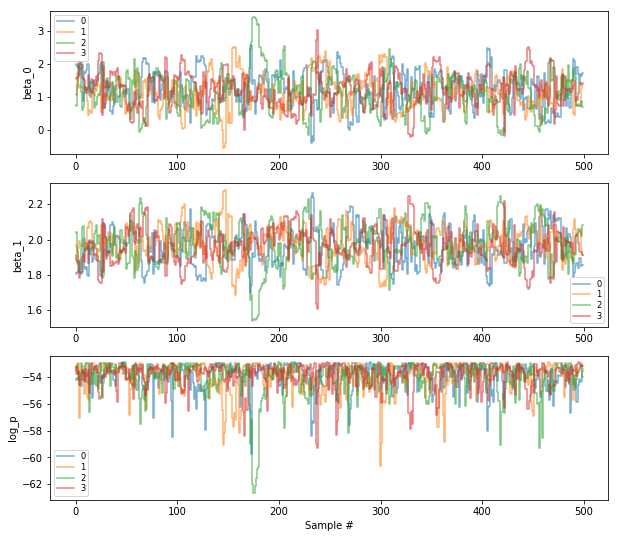

In [12]:
# Check convergence & mixing by examining trace plots.
traceplots(nfit)

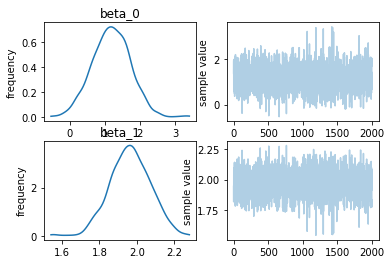

In [13]:
# Stan's default plot, showing a (marginal) PDF (via KDE) and a merged-chains
# trace plot:
fig = nfit.stan_plot()

Thinning chains by 2


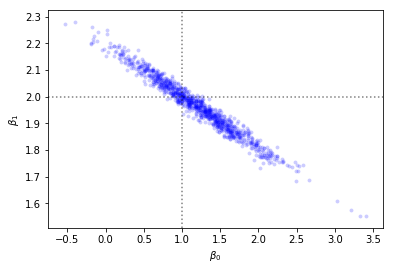

In [14]:
# Plot joint posterior.
betas_plot(nfit, beta_0, beta_1)

## 1. Uniform marginal case

Use PyStan to fit the data generated from the uniform marginal joint distribution, using a model that accurately describes the data generation process.

### Problem 1.1 (3 points):

> * Reproduce the above analysis (starting at the "*Normal marginal case*" heading), but write a new Stan model for regression with a uniform marginal, and fit the data generated above from the uniform marginal case.

## 2. Model misspecification and conditional independence

When the model adopted to analyze a dataset does not accurately describe the data generation process, one says the model is *misspecified*. One should of course always try to model the data as accurately as possible, but truly accurate modeling is often impossible with real-world data. The influence of model misspecification on inferences can be dramatic or subtle, sometimes in surprising ways.

### Problem 2.1 (1 point):

> * Use the **normal marginal model** (as provided in the assignment, above; i.e., `nfitter`) **to fit the uniform marginal data**, reproducing the sequence of fitting steps you used in problem 1 (you don't need to redefine the model).

### Problem 2.2 (2 points):

> Consider the regression coefficient estimates (e.g., summaries, marginals, and scatterplots) from
 - The fit of the uniform case model to the uniform case data (in Problem 1), that is, the fit using an **accurate model**;
 - The fit you just did, that is, a fit with a **misspecified model**.
 
> Note whether the results look significantly different or substantially the same, and briefly explain why they differ or appear the same.